In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score





[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cesiu\AppData\Roaming\nltk_data...


In [11]:
# !pip install google-colab
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-vision
# !pip install --upgrade google-api-python-client

from google.colab import drive
drive.mount('/content/gdrive')
file_1='/content/gdrive/MyDrive/sentiment_analysis.csv' 
df = pd.read_csv(file_1, header=[0])


ModuleNotFoundError: No module named 'google.colab'

In [60]:
# df = pd.read_csv("sentiment_analysis.csv", header=[0])

In [61]:
display(df)

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [62]:
# remove ID column
df.drop('ID', axis=1, inplace=True)

In [63]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    # text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove user tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r'^RT ', '', text) # Remove Retweet
    return text.lower()

df['cleaned_text'] = df['text'].apply(clean_text)

In [64]:
display(df)

,text,label,cleaned_text
0,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins is looking forward to tab breeder...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,congratulations pakistan on becoming no1testt...
2,"RT @PEPalerts: This September, @YESmag is taki...",1,this september is taking you to maine mendoz...
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,newly painted walls thanks a million to our c...
4,RT @CedricFeschotte: Excited to announce: as o...,1,excited to announce as of july 2017 feschotte...
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,i cant stop watching hermm more
550387,Poor old Tom Odell doesn't look like he would ...,0,poor old tom odell doesnt look like he would k...
550388,#antsmasher I smashed 7 ants in this awesome ...,1,antsmasher i smashed 7 ants in this awesome g...
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,morning girls have a wonderful friday


In [65]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'],df['label'], test_size=0.2, random_state=1624)

In [66]:
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [67]:
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [68]:
# select 1000 best features by chi2
# TF-IDF
k = 1000 
selector = SelectKBest(chi2, k=k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

In [69]:
# Bag of Words
selector = SelectKBest(chi2, k=k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)

In [70]:
# TF-IDF Logistic Regression
lr_tfidf = LogisticRegression(max_iter=5000)
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}
grid_search_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, cv=5)
grid_search_lr_tfidf.fit(X_train_tfidf_selected, y_train)

# Bag of Words Logistic Regression
lr_bow = LogisticRegression(max_iter=5000)
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}
grid_search_lr_bow = GridSearchCV(lr_bow, param_grid, cv=5)
grid_search_lr_bow.fit(X_train_bow_selected, y_train)

# Evaluate the models
lr_tfidf_acc = grid_search_lr_tfidf.score(X_test_tfidf_selected, y_test)
lr_bow_acc = grid_search_lr_bow.score(X_test_bow_selected, y_test)

In [71]:
print(lr_tfidf_acc)
print(lr_bow_acc)

0.9556863706974082
0.9544690631273903


In [72]:
# TF-IDF Naive Bayes
nb_tfidf = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}
grid_search_nb_tfidf = GridSearchCV(nb_tfidf, param_grid, cv=5)
grid_search_nb_tfidf.fit(X_train_tfidf_selected, y_train)

# Bag of Words Naive Bayes
nb_bow = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}
grid_search_nb_bow = GridSearchCV(nb_bow, param_grid, cv=5)
grid_search_nb_bow.fit(X_train_bow_selected, y_train)

# Evaluate the models
nb_tfidf_acc = grid_search_nb_tfidf.score(X_test_tfidf_selected, y_test)
nb_bow_acc = grid_search_nb_bow.score(X_test_bow_selected, y_test)

In [73]:
print(nb_tfidf_acc)
print(nb_bow_acc)

0.9121449141071413
0.9391709590385087


In [74]:
# TF-IDF Decision Tree
dt_tfidf = DecisionTreeClassifier()
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}
grid_search_dt_tfidf = GridSearchCV(dt_tfidf, param_grid, cv=5)
grid_search_dt_tfidf.fit(X_train_bow_selected, y_train)

# Bag of Words Decision Tree
dt_bow = DecisionTreeClassifier()
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}
grid_search_dt_bow = GridSearchCV(dt_bow, param_grid, cv=5)
grid_search_dt_bow.fit(X_train_bow_selected, y_train)

# Evaluate the models
dt_tfidf_acc = grid_search_dt_tfidf.score(X_test_tfidf_selected, y_test)
dt_bow_acc = grid_search_dt_bow.score(X_test_bow_selected, y_test)

In [75]:
print(dt_tfidf_acc)
print(dt_bow_acc)

0.6753876761235112
0.7929487004787471


In [ ]:
# TF-IDF XGBoost
xgb_tfidf = XGBClassifier()
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}
grid_search_xgb_tfidf = GridSearchCV(xgb_tfidf, param_grid, cv=5)
grid_search_xgb_tfidf.fit(X_train_bow_selected, y_train)

# Bag of Words XGBoost
xgb_bow = XGBClassifier()
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}
grid_search_xgb_bow = GridSearchCV(xgb_bow, param_grid, cv=5)
grid_search_xgb_bow.fit(X_train_bow_selected, y_train)

# Evaluate the models
xgb_tfidf_acc = grid_search_xgb_tfidf.score(X_test_tfidf_selected, y_test)
xgb_bow_acc = grid_search_xgb_bow.score(X_test_bow_selected, y_test)

In [ ]:
print(xgb_tfidf_acc)
print(xgb_bow_acc)

In [ ]:
print("Logistic Regression Accuracy - TF-IDF: {:.2f}, BoW: {:.2f}".format(lr_tfidf_acc, lr_bow_acc))
print("Naive Bayes Accuracy - TF-IDF: {:.2f}, BoW: {:.2f}".format(nb_tfidf_acc, nb_bow_acc))
print("Decision Tree Accuracy - TF-IDF: {:.2f}, BoW: {:.2f}".format(dt_tfidf_acc, dt_bow_acc))
print("XGBoost Accuracy - TF-IDF: {:.2f}, BoW: {:.2f}".format(xgb_tfidf_acc, xgb_bow_acc))

XGBoost with Bag of Words has the best accuracy.

In [ ]:
grid_search_xgb_bow.best_params_

In [78]:
XGBClassifier(learning_rate= 0.5, max_depth= 10, n_estimators= 500)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Part-2

## Applying models

### part1 model

In [120]:
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

In [121]:
#Select feature using the previous selector
selector = SelectKBest(chi2, k=1000)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)

In [122]:
#Apply the best model trained in Part1
xgbbest = XGBClassifier(learning_rate= 0.5, max_depth= 10, n_estimators= 500,random_state = 1624)
xgbbest.fit(X_train_bow_selected,y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1624, ...)

### Pretrained model- Vader

In [123]:
# Apply a pretrained model Vader and compute a threshold
def pre_label(df,column):
    df1=df.copy(deep=True)
    model = SentimentIntensityAnalyzer()
    df_pred = [*df1[column].apply(model.polarity_scores)]
    neglst = []
    neulst = []
    poslst = []
    compoundlst = []
    for i in df_pred:
        neglst.append(i['neg'])
        poslst.append(i['pos'])
        neulst.append(i['neu'])
        compoundlst.append(i['compound'])
    dfpred = pd.DataFrame({'neg':neglst, 'pos':poslst,'neu': neulst, 'compound': compoundlst})
    df1['compound'] = dfpred['compound'].tolist()
    df1 = df1.dropna()
    threshold = df1['compound'].mean()
    print(threshold)
     # compute y-lables using pretrain model
    df1['label'] = 0
    df1.loc[df1['compound'] >= threshold, 'label'] = 1
    return df1

## New dataset 1-reddit_raw_ukraine_russia.csv

### Data cleaning

In [124]:
# check the string is english or not
def is_english_only_string(s):
    return not bool(re.search('[^\x00-\x7F]+', s))

In [125]:
newdata1 = pd.read_csv('/content/gdrive/MyDrive/reddit_raw_ukraine_russia.csv')
newdata1 = newdata1['comments'].dropna() # drop none value in newdata set
newdata1_all = newdata1.copy(deep=True)
newdata1_all = pd.DataFrame(newdata1_all) # create a new dataframe contains all languages
newdata1_eng = newdata1_all[newdata1_all.comments.map(lambda x:is_english_only_string(x))] # filter the english strings

In [126]:
newdata1_all['cleaned_text'] = newdata1_all['comments'].apply(clean_text)
newdata1_eng['cleaned_text'] = newdata1_eng['comments'].apply(clean_text)

In [127]:
newdata1

0        Hello /u/hjgbuijhgh,\n\nThis community is focu...
1        uhm thats quite the increase.  \n\n\nI also he...
2        Poland also announced that they plan to double...
3        Remember, NATO knows more than we’re being tol...
4        Well done, Putin. Top 2022 salesman of NATO. \...
                               ...                        
16702    not the region where you wanna practice Russia...
16703    Only Estonia is far from the USA. If in the US...
16704    The Russians can jump through the hoops to acq...
16705    At this point Russia will invade anyone it wan...
16706    *"Estonian and Ukrainian languages are bold an...
Name: comments, Length: 16707, dtype: object

### Prediction

In [128]:
#Vader--English comments
df,column = newdata1_eng, 'comments'
dfnew1_eng = pre_label(df,column)

dfnew1_eng_c = dfnew1_eng['comments'] # select the column 'comments' of new dataset1(English)
# Bag of Words--English comments
dfnew1_eng_c = vectorizer.transform(dfnew1_eng_c)
dfnew1_eng_c = selector.transform(dfnew1_eng_c)

pred1_eng = xgbbest.predict(dfnew1_eng_c) # return y prediction values of new dataset1(English)

-0.06999917588375625


In [129]:
#Vader--English comments
df,column = newdata1_all, 'comments'
dfnew1_all = pre_label(df,column)
dfnew1_all_c = dfnew1_all['comments'] # select the column 'comments' of new dataset1 (all languages)

# Bag of Words--All comments
dfnew1_all_c = vectorizer.transform(dfnew1_all_c)
dfnew1_all_c = selector.transform(dfnew1_all_c)

pred1_all = xgbbest.predict(dfnew1_all_c) # return y prediction values of new dataset1(all languages)

-0.07447011432333753


In [130]:
# compute accuracy between pretrained model and xgboost model
allv = dfnew1_all['label'].tolist()
allxb = pred1_all.tolist()
engv = dfnew1_eng['label'].tolist()
engxb = pred1_eng.tolist()
print('All language accuracy: {} \nEnglish only accuracy: {}'.format(accuracy_score(allv, allxb),accuracy_score(engv, engxb)))

All language accuracy: 0.5954988926797151 
English only accuracy: 0.5893876960890624


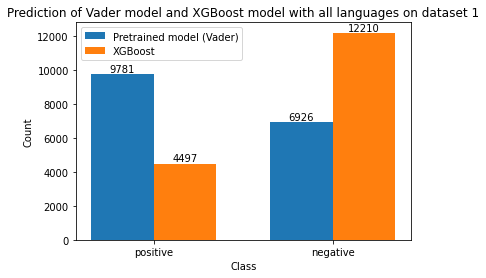

In [131]:
import matplotlib.pyplot as plt

labels = ['positive', 'negative']
values1 = [len([x for x in allv if x == 1]), 
           len([x for x in allv if x == 0])]
values2 = [len([x for x in allxb if x == 1]),
           len([x for x in allxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()


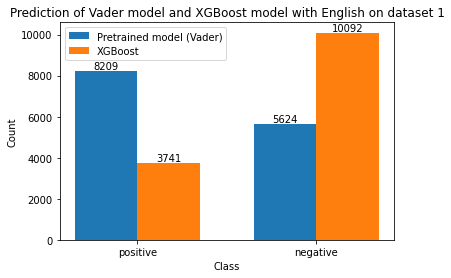

In [132]:
labels = ['positive', 'negative']
values3 = [len([x for x in engv if x == 1]), 
           len([x for x in engv if x == 0])]
values4 = [len([x for x in engxb if x == 1]),
           len([x for x in engxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p3 = plt.bar(labels, values3, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p4 = plt.bar([i + width for i in range(len(values4))], values4, width, label='XGBoost')
plt.bar_label(p3)
plt.bar_label(p4)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with English on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()

##New dataset 2 -russian_invasion_of_ukraine.csv

In [133]:
file_2='/content/gdrive/MyDrive/russian_invasion_of_ukraine.csv'

df_inv_tmp=pd.read_csv(file_2, header=[0])

In [134]:
df_inv_tmp.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Live updates: Russians destroy Chernobyl labor...,56,tkjwjl,https://www.washingtonpost.com/politics/live-u...,15.0,1.648003e+09,NaN,2022-03-23 02:34:15
1,Romania Is Handing Out 30 Million Anti-Radiati...,265,tkjqga,https://www.vice.com/amp/en/article/pkpw7b/iod...,22.0,1.648002e+09,NaN,2022-03-23 02:25:07
2,Oil rises towards $116 as EU weighs Russian ban,28,tk1utj,https://www.reuters.com/business/energy/oil-op...,2.0,1.647952e+09,NaN,2022-03-22 12:27:29
3,Russia Sends $66 Million Coupon to Depository ...,44,tk1nlm,https://www.bloomberg.com/news/articles/2022-0...,8.0,1.647951e+09,NaN,2022-03-22 12:17:29
4,Ukraine war latest: Global diesel shortage loo...,31,tk1ky3,https://www.ft.com/content/795b432f-b189-4c91-...,3.0,1.647951e+09,NaN,2022-03-22 12:13:26


In [135]:
#Keep the comments part
df_inv=df_inv_tmp[['body']].dropna()
#Convert the datatype to String
df_inv['body'] = df_inv['body'].astype(str)
#Apply the text cleaning function
df_inv['cleaned_text'] = df_inv['body'].apply(clean_text)

In [136]:
df_inv

,body,cleaned_text
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...
13,Russia: 🥺,russia
...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...


In [137]:
#Check language
df_inv_eng = df_inv['cleaned_text'][df_inv['cleaned_text'].map(lambda x:is_english_only_string(x))]

In [138]:
#Check if there are other languages, if True, the comments text all considered English
print(df_inv_eng.shape[0]==df_inv.shape[0])

True


### Prediction

In [139]:
# XGBoost with Bag of Words
df_inv_bow = vectorizer.transform(df_inv['cleaned_text'])
df_inv_bow_selected = selector.transform(df_inv_bow)
#Predict labels using the best model
df_inv_bow_xgbpred=xgbbest.predict(df_inv_bow_selected)

In [140]:
df_inv_bow_xgbpred_tmp=pd.DataFrame(df_inv_bow_xgbpred.astype(int),index=df_inv.index,columns=['label'])
df_inv_bow_xgbpred=pd.concat([df_inv,df_inv_bow_xgbpred_tmp],axis=1)

In [141]:
df_inv_bow_xgbpred

,body,cleaned_text,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,0
13,Russia: 🥺,russia,0
...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,1


In [142]:
# Vader
df_inv_vaderpred=pre_label(df_inv,"cleaned_text")

-0.05395636888298671


In [143]:
df_inv_vaderpred

,body,cleaned_text,compound,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0.0000,1
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,-0.6908,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,-0.2815,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,-0.5568,0
13,Russia: 🥺,russia,0.0000,1
...,...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,-0.4854,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,-0.2732,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0.3252,1
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,0.9338,1


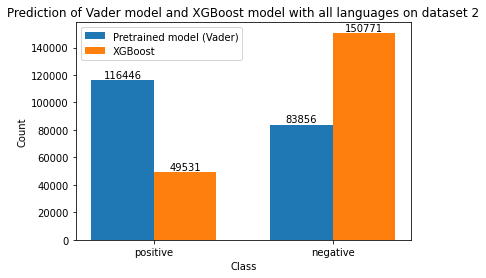

In [144]:
labels = ['positive', 'negative']
values1 = [len([x for x in df_inv_vaderpred['label'] if x == 1]), 
           len([x for x in df_inv_vaderpred['label'] if x == 0])]
values2 = [len([x for x in df_inv_bow_xgbpred['label'] if x == 1]),
           len([x for x in df_inv_bow_xgbpred['label'] if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 2')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()
